In [1]:
import warnings
warnings.filterwarnings("ignore")
import torch

import pandas as pd
import numpy as np
import scanpy as sc
import os
import yaml
from pathlib import Path
from tqdm import tqdm


os.environ["CUDA_VISIBLE_DEVICES"] = "0"
#os.environ['R_HOME'] = 'D:/software/R/R-4.3.2'
#os.environ['R_USER'] = 'D:/software/anaconda/anaconda3/envs/pt20cu118/Lib/site-packages/rpy2'
from sklearn.decomposition import PCA

import STG3Net as MODEL

def mapping2int(string_array):
    mapping = {}
    result = []
    for string in string_array:
        if string not in mapping:
            mapping[string] = len(mapping)
        result.append(mapping[string])
    return result, mapping

def get_data(proj_list, config):
    global graph_dict
    data_root = Path('../../data/DLPFC')
    result, mapping = mapping2int(proj_list)
    for proj_name in tqdm(proj_list):
        adata_tmp = sc.read_visium(data_root / proj_name, count_file=proj_name + "_filtered_feature_bc_matrix.h5")
        adata_tmp.var_names_make_unique()

        adata_tmp.obs['batch_name'] = proj_name
        adata_tmp.obs['slice_id'] = mapping[proj_name]

        ##### Load layer_guess label, if have
        truth_path = "../../data/DLPFC/" + proj_name + '/' + 'manual_annotations.txt'
        Ann_df = pd.read_csv(truth_path, sep='\t', header=None, index_col=0)
        Ann_df.columns = ['Ground Truth']
        adata_tmp.obs['layer_guess'] = Ann_df.loc[adata_tmp.obs_names, 'Ground Truth']
        adata_tmp = adata_tmp[~pd.isnull(adata_tmp.obs['layer_guess'])]

        graph_dict_tmp = MODEL.graph_construction(adata_tmp, config['k_cutoff'])
        if proj_name == proj_list[0]:
            adata = adata_tmp
            graph_dict = graph_dict_tmp
            name = proj_name
            adata.obs['proj_name'] = proj_name
        else:
            var_names = adata.var_names.intersection(adata_tmp.var_names)
            adata = adata[:, var_names]
            adata_tmp = adata_tmp[:, var_names]
            adata_tmp.obs['proj_name'] = proj_name

            adata = adata.concatenate(adata_tmp)
            graph_dict = MODEL.combine_graph_dict(graph_dict, graph_dict_tmp)
            name = name + '_' + proj_name

    adata.layers['count'] = adata.X.toarray()
    sc.pp.filter_genes(adata, min_cells=50)
    sc.pp.filter_genes(adata, min_counts=10)
    sc.pp.normalize_total(adata, target_sum=1e6)
    sc.pp.highly_variable_genes(adata, flavor="seurat_v3", layer='count', n_top_genes=config['top_genes'])
    adata = adata[:, adata.var['highly_variable'] == True]
    sc.pp.scale(adata)

    adata_X = PCA(n_components=200, random_state=42).fit_transform(adata.X)
    adata.obsm['X_pca'] = adata_X
    return adata, graph_dict

In [ ]:
with open('Config/Config_DLPFC.yaml', 'r', encoding='utf-8') as f:
    config = yaml.load(f.read(), Loader=yaml.FullLoader)

proj_list = ['151507', '151508', '151509', '151510']
num_cluster = 7

adata, graph_dict = get_data(proj_list, config['data'])

 50%|█████     | 2/4 [00:04<00:04,  2.07s/it]

In [ ]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
net = MODEL.G3net(adata, graph_dict=graph_dict, device=device, config=config, num_cluster=num_cluster)

In [ ]:
net.train(verbose=1)

In [ ]:
enc_rep, recon = net.process()
enc_rep = enc_rep.data.cpu().numpy()
recon = recon.data.cpu().numpy()
adata.obsm['latent'] = enc_rep
adata.obsm['recon'] = recon
print(adata)

In [ ]:
adata = net.clustering(adata, num_cluster=num_cluster, used_obsm='latent', key_added_pred='mclust', method='mclust', random_seed=666)

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import adjusted_rand_score as ari_score
from sklearn.metrics import normalized_mutual_info_score as nmi_score
from sklearn.metrics import adjusted_mutual_info_score as ami_score
from sklearn.metrics import homogeneity_score as hom_score
from sklearn.metrics import completeness_score as com_score

In [ ]:
sub_adata = adata[~pd.isnull(adata.obs['layer_guess'])]
ARI = ari_score(sub_adata.obs['layer_guess'], sub_adata.obs['mclust'])
print(f"total ARI:{ARI}")
for name in proj_list:
    sub_adata_tmp = sub_adata[sub_adata.obs['batch_name'] == name]
    ARI = ari_score(sub_adata_tmp.obs['layer_guess'], sub_adata_tmp.obs['mclust'])
    print(f"{name} ARI:{ARI}")

In [ ]:
sub_adata = adata[~pd.isnull(adata.obs['layer_guess'])]
NMI = nmi_score(sub_adata.obs['layer_guess'], sub_adata.obs['mclust'])
print(f"total NMI:{NMI}")
AMI = ami_score(sub_adata.obs['layer_guess'], sub_adata.obs['mclust'])
print(f"total AMI:{AMI}")
for name in proj_list:
    sub_adata_tmp = sub_adata[sub_adata.obs['batch_name'] == name]
    NMI = nmi_score(sub_adata_tmp.obs['layer_guess'], sub_adata_tmp.obs['mclust'])
    AMI = ami_score(sub_adata_tmp.obs['layer_guess'], sub_adata_tmp.obs['mclust'])
    ACC = 1/2 * (NMI + AMI)
    print(f"{name} ACC:{ACC}")

In [ ]:
sub_adata = adata[~pd.isnull(adata.obs['layer_guess'])]
HOM = hom_score(sub_adata.obs['layer_guess'], sub_adata.obs['mclust'])
print(f"total HOM:{HOM}")
COM = com_score(sub_adata.obs['layer_guess'], sub_adata.obs['mclust'])
print(f"total COM:{COM}")
for name in proj_list:
    sub_adata_tmp = sub_adata[sub_adata.obs['batch_name'] == name]
    HOM = hom_score(sub_adata_tmp.obs['layer_guess'], sub_adata_tmp.obs['mclust'])
    COM = com_score(sub_adata_tmp.obs['layer_guess'], sub_adata_tmp.obs['mclust'])
    V =  2 * ((HOM * COM) / (HOM + COM))
    print(f"{name} V:{V}")

In [ ]:
import harmonypy as hm

iLISI = hm.compute_lisi(adata.obsm['latent'], adata.obs[['batch_name']], label_colnames=['batch_name'])[:, 0]
cLISI = hm.compute_lisi(adata.obsm['latent'], adata.obs[['layer_guess']], label_colnames=['layer_guess'])[:, 0]
df_iLISI = pd.DataFrame({
    'method': 'SEDR',
    'value': iLISI,
    'type': ['ILISI'] * len(iLISI)
})

df_cLISI = pd.DataFrame({
    'method': 'SEDR',
    'value': cLISI,
    'type': ['CLISI'] * len(cLISI)
})

fig, axes = plt.subplots(1, 2, figsize=(4, 5))
sns.boxplot(data=df_iLISI, x='method', y='value', ax=axes[0])
sns.boxplot(data=df_cLISI, x='method', y='value', ax=axes[1])
axes[0].set_ylim(1, 3)
axes[1].set_ylim(1, 7)
axes[0].set_title('iLISI')
axes[1].set_title('cLISI')

plt.tight_layout()
print(np.median(iLISI))
print(np.median(cLISI))

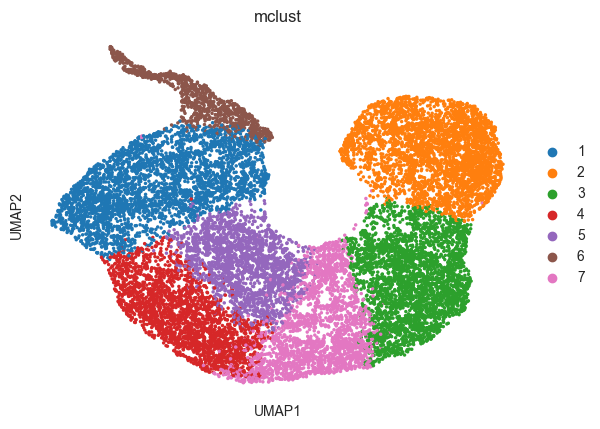

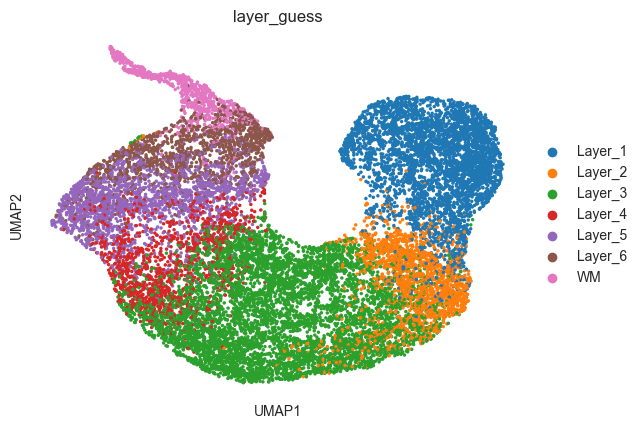

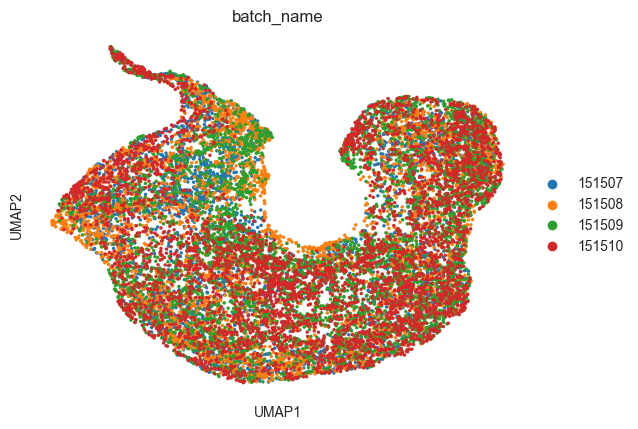

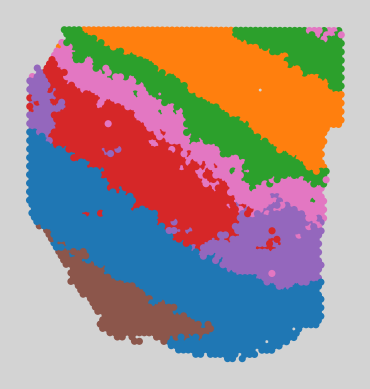

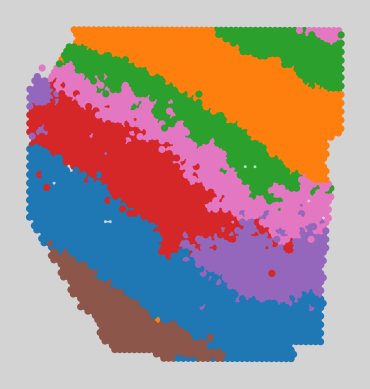

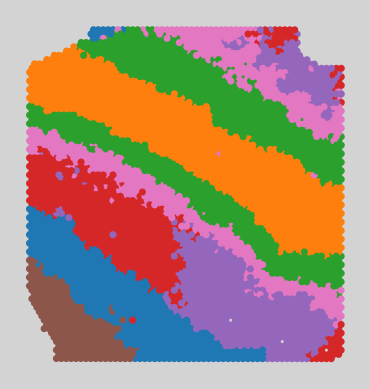

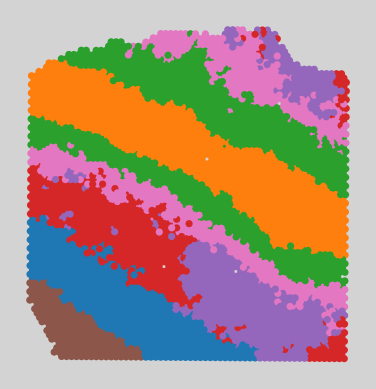

In [13]:
plt.rcParams['axes.facecolor'] = 'white'  # 设置子图的背景颜色
plt.rcParams['figure.facecolor'] = 'white'  # 设置整张图的背景颜色

sc.pp.neighbors(adata, use_rep='latent', random_state=666)
sc.tl.umap(adata, random_state=666)

sc.pl.umap(adata, color=['mclust'], show=True, size=25, save='STG3Net_M_Donor1.png')
sc.pl.umap(adata, color=['layer_guess'], show=True, size=25, save='STG3Net_G_Donor1.png')
sc.pl.umap(adata, color=['batch_name'], show=True, size=25, save='STG3Net_B_Donor1.png')

plt.rcParams['axes.facecolor'] = 'lightgray'  # 设置子图的背景颜色
plt.rcParams['figure.facecolor'] = 'lightgray'  # 设置整张图的背景颜色

for section_id in proj_list:
    adata_tmp = adata[adata.obs['batch_name'] == section_id]
    sc.pl.spatial(adata_tmp, img_key=None, color=['mclust'], title=[''],
                  legend_fontsize=12, show=False, frameon=False, legend_loc=None,
                  spot_size=200)

    plt.savefig('STG3Net_' + section_id + '.png', dpi=300, bbox_inches='tight')

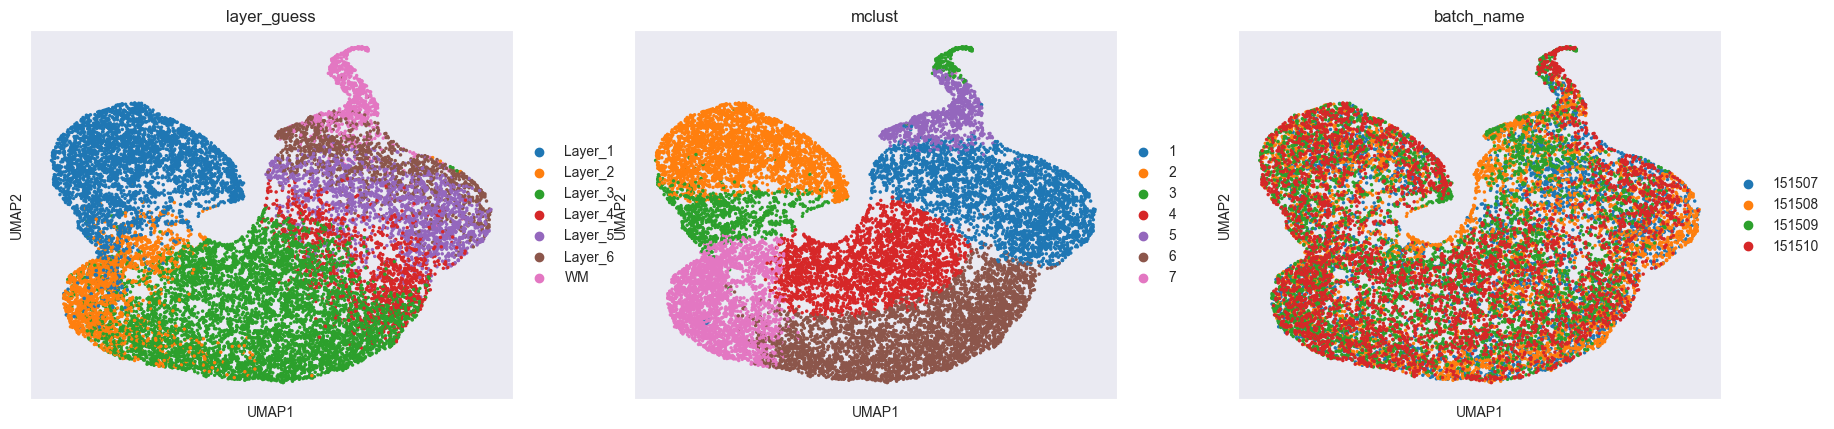

In [12]:
# %%
sc.pp.neighbors(adata, use_rep='latent', metric='cosine')
sc.tl.umap(adata)
sc.pl.umap(adata, color=['layer_guess', 'mclust', 'batch_name'], show=True, size=25, save=False)

In [13]:
Batch_list = []
for section_id in proj_list:
    Batch_list.append(adata[adata.obs['batch_name'] == section_id])

spot_size = 200
title_size = 12
ARI_list = []
for bb in range(len(proj_list)):
    ARI_list.append(round(ari_score(Batch_list[bb].obs['layer_guess'], Batch_list[bb].obs['mclust']), 3))


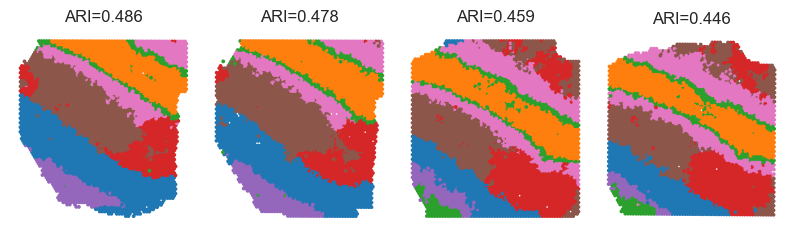

In [14]:
fig, ax = plt.subplots(1, 4, figsize=(10, 5), gridspec_kw={'wspace': 0.05, 'hspace': 0.1})
for idx in range(len(proj_list)):
    _sc_ = sc.pl.spatial(Batch_list[idx], img_key=None, color=['mclust'], title=[''],
                      legend_loc=None, legend_fontsize=12, show=False, ax=ax[idx], frameon=False,
                      spot_size=spot_size)
    _sc_[0].set_title("ARI=" + str(ARI_list[idx]), size=title_size)
plt.show()